In [4]:
import market_data
from datetime import datetime

In [5]:
# Binance API parameters
traded_assets = ['BTC', 'ETH', 'ADA', 'DOGE']
start_date = "Jan 01, 2021"
end_date = "Dec 31, 2021"
stable_assets = ['USDT']
time_horizons = ['1hr', '12hr', '1wk']

# EMA parameters
alpha_values = [0.25, 0.5, 0.75]

# labeling parameters
change_tolerances = []
trend_reversal_tresholds = []

In [6]:
for traded_asset in traded_assets:
    for stable_asset in stable_assets:
        for time_horizon in time_horizons:
            for alpha in alpha_values:
                df_raw = market_data.fetchBinance(
                        traded_asset=traded_asset,
                        stable_asset=stable_asset,
                        time_frame=time_horizon,
                        start_date=start_date,
                        end_date=end_date
                    )
                
                # only 'open' and 'close' needed for moving average calculation
                df = df_raw[['open', 'close', 'closeTime']].copy()
                df['close_ema'] = df['close'].ewm(alpha=alpha).mean()

                # convert time from unix to human readable for r plotting
                for i in range(len(df)):
                    df.loc[i, 'close_time_parsed'] = datetime.utcfromtimestamp(df.loc[i, 'closeTime']//1_000).strftime('%Y-%m-%d %H:%M:%S')

                df.to_csv(f'data/{traded_asset}_{stable_asset}_{time_horizon}_{alpha}_ema.csv', index=False)


In [7]:
df

,open,close,closeTime,close_ema,close_time_parsed
0,33000.05,38150.02,1610323199999,38150.020000,2021-01-10 23:59:59
1,38150.02,35828.61,1610927999999,36292.892000,2021-01-17 23:59:59
2,35824.99,32259.90,1611532799999,33220.136190,2021-01-24 23:59:59
3,32259.45,33092.98,1612137599999,33124.395059,2021-01-31 23:59:59
4,33092.97,38795.69,1612742399999,37382.024106,2021-02-07 23:59:59
5,38795.69,48577.79,1613347199999,45780.899033,2021-02-14 23:59:59
6,48580.47,57408.57,1613951999999,54502.184563,2021-02-21 23:59:59
7,57412.35,45135.66,1614556799999,47477.183948,2021-02-28 23:59:59
8,45134.11,50971.75,1615161599999,50098.118485,2021-03-07 23:59:59
9,50959.11,58968.31,1615766399999,56750.768466,2021-03-14 23:59:59


In [10]:
print(datetime.utcfromtimestamp(1609469999999//1_000).strftime('%Y-%m-%d %H:%M:%S'))

2021-01-01 02:59:59


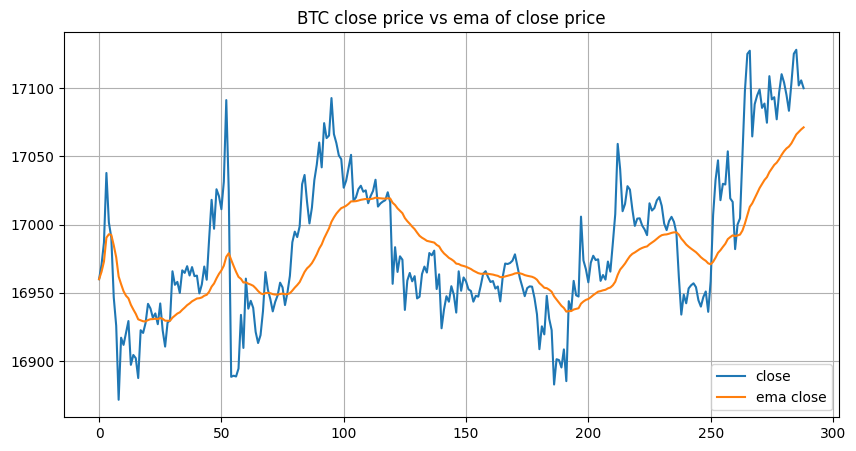

In [29]:
# # close vs ema close
# plt.figure(figsize=(10, 5))

# plt.subplot()
# plt.plot(df['close'], label = 'close')
# plt.plot(df['close_ema'], label = 'ema close')
# plt.grid()
# plt.title("BTC close price vs ema of close price")
# plt.legend(
#     loc='lower right'
# )